In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import glob
import pickle
import cv2

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display


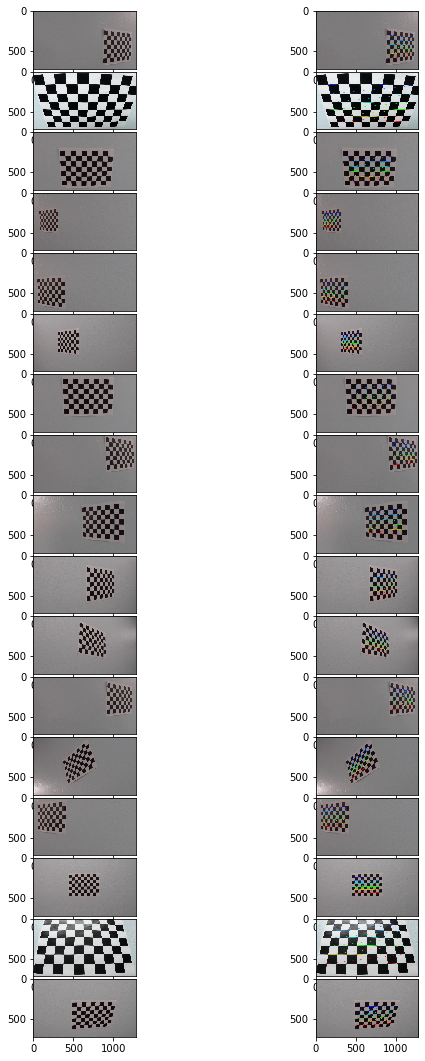

In [2]:
#save and load functions to work with dict using pickle
def load_dict(filename):
    dict = pickle.load(open(filename, "rb" ))
    return dict

def save_dict(dict,filename):
    pickle.dump(dict, open(filename, "wb+" ))
    return

#camera calibration
#In this section, calibration coefficients based on different chess board chessboard 
path_cal_images = "camera_cal/calibration*.jpg"
ncol = 2
nrow = len(path_cal_images)   
plt.figure(figsize = (10,30))
gs1 = gridspec.GridSpec(nrow, ncol)
gs1.update(wspace=0.025, hspace=0.05)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
i=0
#
for idx, image in enumerate(glob.glob(path_cal_images)):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        ax1 = plt.subplot(gs1[i])
        ax1.imshow(img)
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ax1 = plt.subplot(gs1[i+1])
        ax1.imshow(img)
        i +=2
    
    # Draw and display the corners
    # cv2.drawChessboardCorners(img, (9,6), corners, ret)
    # now we can use our points to find calibration coefficients
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720,1280), None, None)

#definition of calibration dict and saving it as calib.p using pickle
calibDict = {}
calibDict["mtx"] = mtx
calibDict["dist"] = dist
save_dict(calibDict,"calib.p")


Looking at the images above, the calibration corners have been found for 17 images of 20.

In [3]:
#function to undistort input image 
def undistort(img): 
    #a function to undistort an image
    calibDict=load_dict("calib.p")
    undist = cv2.undistort(img, calibDict["mtx"], calibDict["dist"], None, calibDict["mtx"])
    return undist


In [19]:
def saturation_threshold(image, minv, maxv):
    #Threshold  of S channel HSL color space
    imageholder = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = imageholder[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[np.logical_and(s_channel > minv , s_channel < maxv)] = 1
    return binary_output

def red_threshold(image, minv, maxv):
    #RGB Red channel threshold
    imageholder = image.copy()
    r_channel = imageholder[:,:,0]
    binary_output = np.zeros_like(r_channel)
    binary_output[np.logical_and(r_channel > minv, r_channel < maxv)] = 1
    return binary_output

def YUV_threshold(image, minv, maxv):
    #Y channel of YUV threshold
    imageholder = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    y_channel = imageholder[:,:,0]
    binary_output = np.ones_like(y_channel)
    binary_output[np.logical_and(y_channel > minv , y_channel < maxv)] = 0
    return binary_output

def gradient_threshold(image, thresholds):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #gradient in x and y direction
    sobelx = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=15))
    sobely = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=15))
    
    #normalized gradient in x and y direction
    nsobelx = np.array([255*sobelx/(np.max(sobelx))])[0,:,:]
    nsobely = np.array([255*sobely/(np.max(sobely))])[0,:,:]
    
    #magntiude of gradient
    magnitude = np.sqrt(np.power(nsobelx,2) + np.power(nsobely,2))
    magnitude = np.array([255*magnitude/(np.max(magnitude))])[0,:,:]
    
    #direction of gradient 
    direction = np.arctan(sobely,sobelx)
    
    binary_output = np.zeros_like(gray)
    binary_output[np.logical_and(nsobelx >  thresholds[0], nsobelx <  thresholds[1]) | \
                  np.logical_and(nsobely >  thresholds[2], nsobely <  thresholds[3]) | \
                  np.logical_and(magnitude >  thresholds[4], magnitude <thresholds[5]) | \
                  np.logical_and(direction >  thresholds[6], direction <thresholds[7])] = 1

    return  binary_output


def null_fitness():
    fitDict = {}
    fitDict["left_fit"] =  []
    fitDict["right_fit"] = []
    save_dict(fitDict,"fitnessLR.p")
null_fitness()

In [25]:
def binary_lanes(image,minS=131, maxS=227, minR=127, maxR=127, minY=6, maxY=206,  mainsobelx=127, maxsobelx=127, minsobely=127, maxsobely=127, minma=127, maxma=127, mindir=127, maxdir=127):

    sat = saturation_threshold(image, minS, maxS)
    y = YUV_threshold(image, minY, maxY)
    #red = red_threshold(image, minR, maxR)
    color_combined = np.zeros_like(sat)
    color_combined= cv2.bitwise_or(sat, y)
    #color_combined= cv2.bitwise_or(color_combined, red)
    gradient_combined=gradient_threshold(image,[mainsobelx,maxsobelx,minsobely,maxsobely,minma,maxma,mindir, maxdir])
    cg_combine = np.zeros_like(sat)
    cg_combine = cv2.bitwise_and(gradient_combined, color_combined)
    return color_combined

image = mpimg.imread("test_images/test1.jpg")

def interactive_mask(minS, maxS, minR, maxR, minY, maxY,  mainsobelx, maxsobelx, minsobely, maxsobely, minma, maxma, mindir, maxdir):
    combined = binary_lanes(image, minS, maxS, minR, maxR, minY, maxY,  mainsobelx, maxsobelx, minsobely, maxsobely, minma, maxma, mindir, maxdir)
    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')

interact(interactive_mask, minS=(0,255), maxS=(0,255), minR=(0,255),\
         maxR=(0,255), minY=(0,255), maxY=(0,255),\
         mainsobelx=(0,255), maxsobelx=(0,255), minsobely=(0,255),maxsobely=(0,255), minma=(0,255),maxma=(0,255), mindir=(0, np.pi/2), maxdir = (0, np.pi/2))

interactive(children=(IntSlider(value=127, description='minS', max=255), IntSlider(value=127, description='max…

<function __main__.interactive_mask(minS, maxS, minR, maxR, minY, maxY, mainsobelx, maxsobelx, minsobely, maxsobely, minma, maxma, mindir, maxdir)>

##### The results above show the effect of different thresholdings and their combination on finding the lanes

### - now we wrap the images to bird's eye view

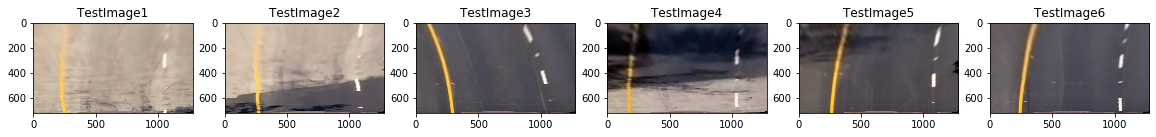

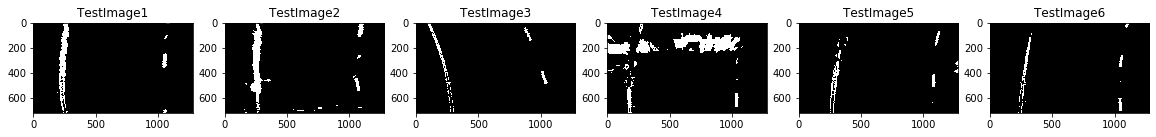

In [26]:
#source and destintion coordinates to warp an image
src = np.float32(
    [[270,  700],  
     [595,  460],  
     [725,  460],  
     [1130, 700]]) 

dst = np.float32(
    [[250,  720], 
     [250,    0],  
     [1065,   0], 
     [1065, 720]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)


def warp(img, M):
    #function to warp an image
    warped = cv2.warpPerspective(img, M, (1280,720))
    return warped

#calcualte median and choose bottom half to calculate histogram
i = 0
fig2, axs2 = plt.subplots(1,6, figsize=(20,50))
for image in glob.glob("test_images/test*.jpg"):
    img = mpimg.imread(image)
    img = undistort(img)
    warped =warp(img,M)
    median_warped = cv2.medianBlur(warped,3,0)
    histogram = np.sum(median_warped[warped.shape[0]//2:warped.shape[0],:], axis = 0)
    axs2[i].imshow(warped, cmap = "gray")
    axs2[i].set_title("TestImage{}".format(i+1))
    i +=1
i = 0
fig3, axs3 = plt.subplots(1,6, figsize=(20,50))
for image in glob.glob("test_images/test*.jpg"):
    img = mpimg.imread(image)
    img = undistort(img)
    binary = binary_lanes(img)
    warped =warp(binary,M)
    median_warped = cv2.medianBlur(warped,3,0)
    histogram = np.sum(median_warped[warped.shape[0]//2:warped.shape[0],:], axis = 0)
    axs3[i].imshow(warped, cmap = "gray")
    axs3[i].set_title("TestImage{}".format(i+1))
    i +=1


###### The next steps are the following:
- undistort each image
- apply thresholding: gradiant, gradient amplitude, gradiant direction, S channel and Y channel 
- warp the image
- find lane points: moving rectangles and then searching in the vicinity

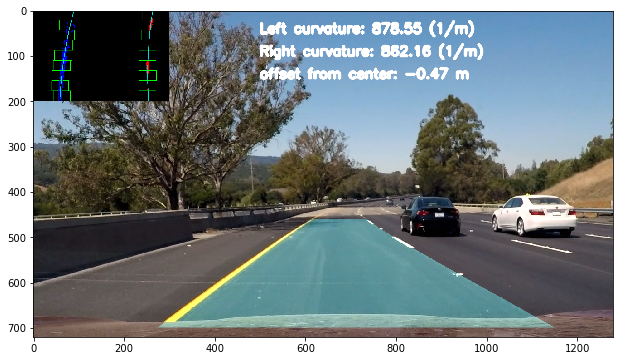

In [27]:
def histogram_max(img):
    median_warped = cv2.medianBlur(img,15,0)
    img_lower_half = img[img.shape[0]//2:,:]
    histo = np.sum(img_lower_half, axis = 0)
    hist_mittel = np.int(histo.shape[0]//2)
    right_half = np.argmax(histo[:hist_mittel]) #value index
    left_half= np.argmax(histo[hist_mittel:]) + hist_mittel #value index
    return [left_half, right_half]

def moving_box(warped):
    #search for the lanes with moving boxes
    left_lane = []
    right_lane = [] 
    out_img = np.dstack((warped, warped, warped))
    leftx, rightx = histogram_max(warped)
        #do sliding window
    nWindows = 9
    width = 80
    minp = 40 # minimum number of points to recenter leftx_current and rightx_current
    heightWindow = np.int(warped.shape[0]//nWindows)
    nonzero = warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
        
    leftx_current = leftx
    rightx_current = rightx
        
    for window in range(nWindows):
        win_y_high = warped.shape[0] - window*heightWindow
        win_y_low = warped.shape[0] - (window+1)*heightWindow
            
        win_xleft_low = leftx_current - width
        win_xleft_high = leftx_current+ width
            
        win_xright_low = rightx_current - width
        win_xright_high = rightx_current + width
            
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
            
        if len(good_left_inds) > minp:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minp:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds])) 
             
            
        leftx = nonzerox[good_left_inds]
        lefty = nonzeroy[good_left_inds]
        rightx = nonzerox[good_right_inds]
        righty = nonzeroy[good_right_inds]
        out_img[lefty,leftx] = (255,0,0)
        out_img[righty,rightx] = (0,0,255)

            
        left_lane =np.append(left_lane, good_left_inds)
        right_lane =np.append(right_lane, good_right_inds)

            #left_lane = np.concatenate(left_lane)
            #right_lane = np.concatenate(right_lane)
                
    left_lane = left_lane.astype(int)
    right_lane = right_lane.astype(int)
        
    leftx = nonzerox[left_lane]
    lefty = nonzeroy[left_lane]
    rightx = nonzerox[right_lane]
    righty = nonzeroy[right_lane]
    polycoef_left = np.polyfit(lefty,leftx,2)
    polycoef_right = np.polyfit(righty,rightx ,2)  
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])  
    x_left = ploty**2* polycoef_left[0] + ploty*polycoef_left[1] + polycoef_left[2]
    x_right = ploty**2* polycoef_right[0] + ploty*polycoef_right[1] + polycoef_right[2]
    fitDict = {}
    fitDict["left_fit"] =  polycoef_left
    fitDict["right_fit"] = polycoef_right
    save_dict(fitDict,"fitnessLR.p")

    return out_img, ploty, leftx, rightx, lefty, righty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def find_in_vicinity(binary_warped, left_fit, right_fit):
    
    margin = 160
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    fitDict = {}
    fitDict["left_fit"] =   left_fitx
    fitDict["right_fit"] =  right_fitx
    save_dict(fitDict,"fitnessLR.p")
    
    return out_img, ploty, leftx, rightx, lefty, righty

def find_lanes(img, leftx_fit = [], rightx_fit = []):
    
    src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

    dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right


    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    binary = undistort(binary_lanes(img))
    warped =warp(binary,M)  

    
    if len(leftx_fit) == 0 or len(rightx_fit) == 0 :
        out_img, ploty, leftx, rightx, lefty, righty= moving_box(warped)
        
    else:
        try:
            out_img, ploty, leftx, rightx, lefty, righty = find_in_vicinity(warped, leftx_fit, rightx_fit)
            if np.std(leftx) > 60 or np.std(rightx) > 60:
                out_img, ploty, leftx, rightx, lefty, righty= moving_box(warped)
        except:
            out_img, ploty, leftx, rightx, lefty, righty= moving_box(warped)
        
            
    return out_img, ploty, leftx, rightx, lefty, righty

def measure_curvature_meters(ploty,leftx,rightx, lefty, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval =np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 
    return left_curverad, right_curverad

def overlay_lanes_to_image(img, slide_imge,y, x1, x2,y1,y2, M_inv):
    # A function to overlay the found lanes to each image
    polycoef_left = np.polyfit(y1,x1,2)
    polycoef_right = np.polyfit(y2,x2 ,2)
    #calculate curvature
    curvature = measure_curvature_meters(y,x1,x2, y1, y2)
    #offset
    car_pos = (np.min(x1) + np.max(x2))/2
    offset = (1280//2 - car_pos)*3.7/700
    
    ploty = y
    x1 = ploty**2* polycoef_left[0] + ploty*polycoef_left[1] + polycoef_left[2]
    x2 = ploty**2* polycoef_right[0] + ploty*polycoef_right[1] + polycoef_right[2]    
    gray_band = np.ones_like(out)*220
    pointsleft = np.stack((x1.astype(int),y.astype(int))).T
    pointsright = np.stack((x2.astype(int),y.astype(int))).T   
    cv2.polylines(slide_imge,[pointsleft], isClosed = False, thickness = 5, color = (0, 220, 220))
    cv2.polylines(slide_imge,[pointsright], isClosed = False, thickness = 5, color = (0, 220, 220) )
    slide_imge = cv2.resize(slide_imge, (300, 200))

   # slide_image[0:out.shape[0], 0:out.shape[1], :] = out
    pointsleft = np.stack((x1.astype(int),y.astype(int))).T
    pointsright = np.stack((x2.astype(int),y.astype(int))).T
    points = np.vstack((pointsleft, np.flipud(pointsright)))
    lanes_overlay = np.zeros_like(img)
    cv2.fillPoly(lanes_overlay , [points], (54, 255, 255))

    unwarp  =warp(lanes_overlay ,M_inv)
    output = cv2.addWeighted(img, 1, unwarp, 0.3, 1)
   # out = cv2.addWeighted(out, 1, gray_band, 1, 1)
    #output = cv2.addWeighted(output, 0.8, slide_image,1, 0.5)
    output[0:slide_imge.shape[0], 0:slide_imge.shape[1], :] = slide_imge
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1
    color = (255, 255, 255) 
    thickness = 5
    
    text = "Left curvature: {:.2f} (1/m)".format(curvature[0])
    org = (500, 50)
    output = cv2.putText(output, text, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    text = "Right curvature: {:.2f} (1/m)".format(curvature[1])
    org = (500, 100)
    output = cv2.putText(output, text, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    

    org = (500, 150)
    text = "offset from center: {:.2f} m".format(offset)
    output = cv2.putText(output, text, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)    
    
    return output

img = mpimg.imread("test_images/test6.jpg")
out, y, x1, x2,y1,y2 = find_lanes(img)
plt.figure(figsize = (40,6))
plt.imshow(overlay_lanes_to_image(img, out,y, x1, x2,y1,y2, M_inv));


null_fitness()

In [28]:
def pipeline(img):
    #pipeline for video processing
    fitdic = load_dict("fitnessLR.p")
    out, y, x1, x2,y1,y2 = find_lanes(img, leftx_fit =fitdic["left_fit"] , rightx_fit= fitdic["right_fit"])
    image = overlay_lanes_to_image(img,out, y, x1, x2,y1,y2, M_inv)
    return image 

In [31]:
def process_video(videoFileName):
    from moviepy.editor import VideoFileClip

    video_input = VideoFileClip(videoFileName, audio=False)

    processed_video = video_input.fl_image(pipeline)

    video_output = 'project_video_out.mp4'
    processed_video.write_videofile(video_output, audio=False)

    video_input.reader.close()
    return

In [33]:
process_video("project_video.mp4")


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4

Moviepy - Done !
Moviepy - video ready project_video_out.mp4
